# elpaso - All products
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 30 # elpaso
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(4446, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446 entries, 0 to 4445
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            4446 non-null   int64  
 1   dimCustomerMasterId     4446 non-null   int64  
 2   customerNumber          4446 non-null   object 
 3   year                    4446 non-null   int64  
 4   productGrouping         4446 non-null   object 
 5   totalSpent              4446 non-null   float64
 6   recentDate              4446 non-null   object 
 7   attendancePercent       4446 non-null   float64
 8   renewedBeforeDays       4446 non-null   int64  
 9   isBuyer                 4446 non-null   object 
 10  source_tenure           4446 non-null   int64  
 11  tenure                  4446 non-null   int64  
 12  distToVenue             4446 non-null   float64
 13  totalGames              4446 non-null   int64  
 14  recency                 4446 non-null   

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["year",
            "isNextYear_Buyer",
            "productGrouping",
            "dimCustomerMasterId",
         "totalSpent",
        "attendancePercent",
        "source_tenure",
        "tenure",
        "recency",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "is_Lockdown",
        "NumberofGamesPerSeason"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (2988, 15)
Unseen Data For Predictions: (527, 15)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
     "totalSpent",
        "attendancePercent",
        "source_tenure",
        "tenure",
        "recency",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "is_Lockdown",
        "NumberofGamesPerSeason"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8086,0.8870,0.9101,0.7483,0.8211,0.6195,0.6339,0.3540
xgboost,Extreme Gradient Boosting,0.8023,0.8765,0.8399,0.7712,0.8038,0.6053,0.6080,0.3270


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8031,0.8875,0.8943,0.7483,0.8148,0.6082,0.6193
1,0.8268,0.8903,0.9512,0.7548,0.8417,0.6559,0.6775
2,0.8071,0.8864,0.9106,0.7467,0.8205,0.6164,0.6306
3,0.7874,0.8926,0.9024,0.7255,0.8043,0.5775,0.5941
4,0.7953,0.8578,0.8770,0.7431,0.8045,0.5927,0.6017
5,0.7835,0.8613,0.8607,0.7343,0.7925,0.5691,0.5769
6,0.7835,0.9075,0.9098,0.7161,0.8014,0.5707,0.5906
7,0.8268,0.8964,0.9426,0.7566,0.8394,0.6562,0.6750
8,0.8740,0.9154,0.9344,0.8261,0.8769,0.7489,0.7549
9,0.7984,0.8741,0.9180,0.7320,0.8145,0.5998,0.6184


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(931, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
3515,30,394259219,3172725,2021,Full Season,4438.60,2021-09-27,0.269531,30,TRUE,...,0,0,0.0,1,132,0,1,0,0.9928,0.0072
3516,30,394259973,6804029,2021,Paw-tial Plan,276.46,2021-05-29,0.375000,19,TRUE,...,0,0,0.0,1,132,0,0,0,0.9998,0.0002
3517,30,394260025,5261072,2021,Paw-tial Plan,323.00,2021-09-24,0.794118,25,TRUE,...,0,0,0.0,1,132,0,0,0,0.9975,0.0025
3518,30,394260238,5198880,2021,Half Season,863.83,2021-09-19,0.452055,26,TRUE,...,0,0,0.0,1,132,0,1,0,0.9958,0.0042
3519,30,394260277,3208636,2021,Full Season,7532.60,2021-09-07,0.437500,30,TRUE,...,0,0,0.0,1,132,0,0,0,0.9879,0.0121


In [11]:
new_predictions["Label"].value_counts()

0    931
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    930
(0.2, 0.4]         1
(0.4, 0.6]         0
(0.6, 0.8]         0
(0.8, 1.0]         0
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

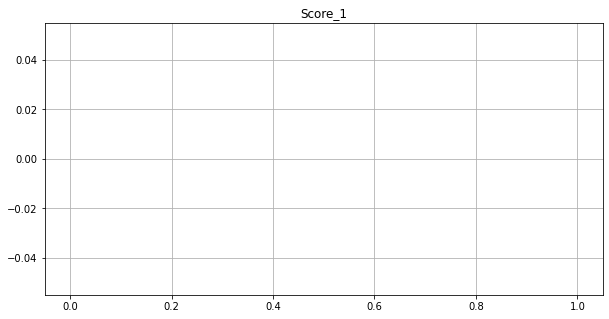

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

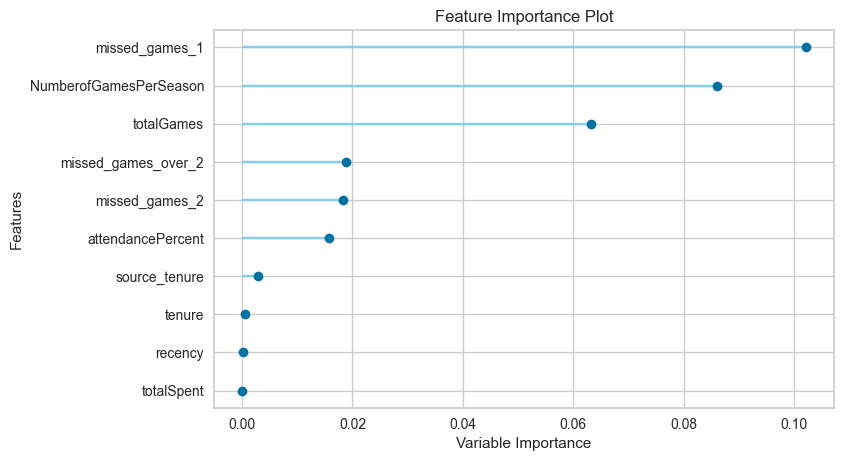

In [14]:
plot_model(best_model, plot='feature')

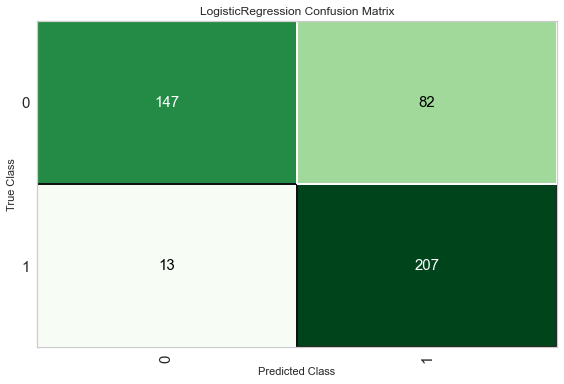

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?